In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import imgaug as ia
import operator
import functools
import random
from PIL import Image
from imgaug import augmenters as iaa
plt.rcParams['image.cmap'] = 'gray'
np.random.seed(98765)


In [2]:
from tf_unet import image_gen
from tf_unet import unet
from tf_unet import util
from tf_unet.image_util import ImageDataProvider

In [3]:
EPOCHS = 100
PATCH_SIZE = 128
MARGIN = 30
DISCREET_MASK = True

In [4]:
def randomCrop(img, mask, width, height):
    assert img.shape[0] >= width
    assert img.shape[1] >= height
    assert img.shape[0] == mask.shape[0]
    assert img.shape[1] == mask.shape[1]
    x = random.randint(0, img.shape[0] - width)
    y = random.randint(0, img.shape[1] - height)
    img = img[x:x+width, y:y+height]
    mask = mask[x:x+width, y:y+height]
    return img, mask, x, y

In [5]:
# def randomPatch(img, mask, width, height):
#     img_cropped, mask_cropped, x_offset, y_offset = randomCrop(img, mask, width, height)
    
#     fliplr_random = np.random.random() > 0.5
#     flipud_random = np.random.random() > 0.5
    
#     if fliplr_random:
#         img_cropped = np.fliplr(img_cropped)
#         mask_cropped = np.fliplr(mask_cropped)
        
#     if flipud_random:
#         img_cropped = np.flipud(img_cropped)
#         mask_cropped = np.flipud(mask_cropped)
        
#     return img_cropped, mask_cropped, x_offset, y_offset, fliplr_random, flipud_random
    
    

In [6]:
# Define augmentation
def do_augment_data(data, labels, flip_ud=True):
    image = data
    mask = labels
    
    flip_ud_prob = 0
    if (flip_ud == True):
        flip_ud_prob = 0.5
    
    # more aggressive augmentation:
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(flip_ud_prob),
        iaa.Crop(percent=(0, 0.05)),
        iaa.Affine(
            scale={"x": (0.90, 1.10), "y": (0.90, 1.10)},
            translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
            rotate=(-45, 45),
            shear=(-5, 5)
        )
    ], random_order = True)

    seq_det = seq.to_deterministic()

    image_aug = seq_det.augment_image(image)
    mask_aug = seq_det.augment_image(mask)

    if (DISCREET_MASK == True):
        # augmentation makes some of these values not discreet, fix them here.
        mask_aug[mask_aug > 0.5] = 1
        mask_aug[mask_aug <= 0.5] = 0
            
    return image_aug, mask_aug

In [7]:
# Create a generator that uses the Image data provider


class GrayImageDataProvider(ImageDataProvider):
    def __init__(self, search_path, a_min=None, a_max=None, data_suffix=".png", mask_suffix='_mask.png', shuffle_data=True, augment_data=False, flip_ud=True):
        self.augment_data = augment_data
        self.flip_ud = flip_ud
        super(GrayImageDataProvider, self).__init__(search_path, a_min, a_max, data_suffix, mask_suffix, shuffle_data)

    def _load_file(self, path, dtype=np.float32):
        #im = equalize(Image.open(path).convert('L'))
        im = Image.open(path).convert('L')
        return np.array(im, dtype)
    
    def _post_process(self, data, labels):
        if (self.augment_data):
            data_aug, labels_aug = do_augment_data(data, labels, self.flip_ud)
        else:
            data_aug, labels_aug = data, labels
        return data_aug, labels_aug;

In [8]:
class CropDataProvider(GrayImageDataProvider):
    def __init__(self, search_path, augment_data=False, size=PATCH_SIZE, only_positive=False, crop_first=True):
        self.size = size
        self.only_positive = only_positive
        self.crop_first = crop_first
        super(CropDataProvider, self).__init__(search_path, augment_data=augment_data, flip_ud=only_positive)
    
    def _post_process(self, data, labels):
        if (self.crop_first == True):
            while(True):
                cropped_data, cropped_labels, x_offset, y_offset = randomCrop(data, labels, self.size, self.size)

                # ignore crops with CACs in the margins
                if ([0,1] in cropped_labels[0:MARGIN, 0:self.size] or
                    [0,1] in cropped_labels[0:self.size, 0:MARGIN] or
                    [0,1] in cropped_labels[-MARGIN:self.size, 0:self.size] or
                    [0,1] in cropped_labels[0:self.size, -MARGIN:self.size]):
                    continue

                if(self.only_positive == True):
                    if (not [0,1] in cropped_labels[MARGIN:-MARGIN, MARGIN:-MARGIN]):
                        continue

                return super(CropDataProvider, self)._post_process(cropped_data, cropped_labels)
        else:
            while(True):
                data_aug, labels_aug = super(CropDataProvider, self)._post_process(data, labels)
                cropped_data, cropped_labels, x_offset, y_offset = randomCrop(data_aug, labels_aug, self.size, self.size)

                # ignore crops with CACs in the margins
                if ([0,1] in cropped_labels[0:MARGIN, 0:self.size] or
                    [0,1] in cropped_labels[0:self.size, 0:MARGIN] or
                    [0,1] in cropped_labels[-MARGIN:self.size, 0:self.size] or
                    [0,1] in cropped_labels[0:self.size, -MARGIN:self.size]):
                    continue                
                
                if(self.only_positive == True):
                    if ([0,1] not in cropped_labels[MARGIN:-MARGIN, MARGIN:-MARGIN]):
                        continue
                return cropped_data, cropped_labels
    
    def _next_data(self):
        while(True):
            img, label = super(CropDataProvider, self)._next_data()
            if(self.only_positive == True and np.amax(label) == False):
                continue
            return img, label
                
    

In [9]:
#generator = GrayImageDataProvider("data/training/*.png", augment_data=True)
generator = CropDataProvider("data/_old_training/training_poster/*.png", augment_data=True, size=PATCH_SIZE, only_positive=True, crop_first=False)
#generator = CropDataProvider("data/training/*.png", augment_data=True, size=PATCH_SIZE)

Number of files used: 1
Number of channels: 1
Number of classes: 2


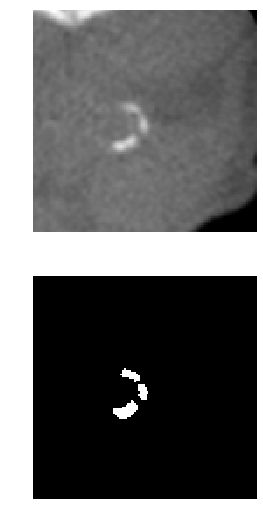

In [10]:
# visualize one of the files

x_test, y_test = generator(1)

fig, ax = plt.subplots(2,1, sharey=True, figsize=(4,9))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

In [11]:
# visualize the augmentation

# x_test, y_test = generator(1)

# image = x_test[0,...,0]
# mask = y_test[0,...,1]

# image_aug, mask_aug = do_augment_data(image, mask)

# fig, ax = plt.subplots(2,2, sharey=True, figsize=(8,8))
# ax[0, 0].imshow(image, aspect="auto")
# ax[1, 0].imshow(image_aug, aspect="auto")
# ax[0, 1].imshow(mask, aspect="auto")
# ax[1, 1].imshow(mask_aug, aspect="auto")



In [12]:
# The network

generator = CropDataProvider("../_data/localizer_training/positive/*.png", augment_data=True, size=PATCH_SIZE, only_positive=True, crop_first=False)
net = unet.Unet(channels=generator.channels, n_class=generator.n_class, layers=3, features_root=32)
#net = unet.Unet(channels=generator.channels, n_class=generator.n_class, layers=3, features_root=32, cost_kwargs=dict(regularizer=0.001, class_weights=[1., 200.]))

2019-08-13 00:38:10,547 Layers 3, features 32, filter size 3x3, pool size: 2x2


Number of files used: 111
Number of channels: 1
Number of classes: 2
Instructions for updating:
Colocations handled automatically by placer.


2019-08-13 00:38:10,566 From /Users/nsemsarilar/code/dl/venv2/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-08-13 00:38:10,585 From /Users/nsemsarilar/code/dl/tf_unet/tf_unet/layers.py:39: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
# Train the model

#trainer = unet.Trainer(net, optimizer="momentum", batch_size=1, opt_kwargs=dict(momentum=0.2))
trainer = unet.Trainer(net, optimizer="adam", verification_batch_size = 4)
path = trainer.train(generator, "./unet_trained", training_iters=32, epochs=EPOCHS, display_step=16)



2019-08-13 00:38:21,575 Removing '/Users/nsemsarilar/code/dl/tf_unet/localizer/prediction'
2019-08-13 00:38:21,583 Removing '/Users/nsemsarilar/code/dl/tf_unet/localizer/unet_trained'
2019-08-13 00:38:21,585 Allocating '/Users/nsemsarilar/code/dl/tf_unet/localizer/prediction'
2019-08-13 00:38:21,586 Allocating '/Users/nsemsarilar/code/dl/tf_unet/localizer/unet_trained'
2019-08-13 00:38:26,544 Verification error= 99.2%, loss= 0.7201
2019-08-13 00:38:26,904 Start optimization
2019-08-13 00:38:27,980 Iter 0, Minibatch Loss= 0.6293, Training Accuracy= 0.9947, Minibatch error= 0.5%
2019-08-13 00:38:41,873 Iter 16, Minibatch Loss= 0.1171, Training Accuracy= 0.9916, Minibatch error= 0.8%
2019-08-13 00:39:03,646 Epoch 0, Average loss: 0.1491, learning rate: 0.0010
2019-08-13 00:39:04,095 Verification error= 0.8%, loss= 0.0888
2019-08-13 00:39:09,578 Iter 32, Minibatch Loss= 0.0831, Training Accuracy= 0.9947, Minibatch error= 0.5%
2019-08-13 00:39:27,439 Iter 48, Minibatch Loss= 0.0754, Trainin

In [ ]:
# Continued training (restore, use both negative and positive values)

negGenerator = CropDataProvider("../_data/localizer_training/all/*.png", augment_data=True, size=PATCH_SIZE, only_positive=False, crop_first=False)
net = unet.Unet(channels=negGenerator.channels, n_class=negGenerator.n_class, layers=3, features_root=32)
trainer = unet.Trainer(net, optimizer="adam", verification_batch_size = 4)
path = trainer.train(negGenerator, "./unet_trained", restore=True, training_iters=32, epochs=EPOCHS, display_step=16)



In [ ]:
# Test the model

testGenerator = GrayImageDataProvider("data/10_169.png", data_suffix=".png", mask_suffix=".png", augment_data=False)
#testGenerator = CropDataProvider("data/test/*.png", augment_data=False, size=PATCH_SIZE, only_positive=False)
x_test, y_test = testGenerator(1)
testNet = unet.Unet(channels=testGenerator.channels, n_class=testGenerator.n_class, layers=3, features_root=32)
prediction = testNet.predict("./unet_trained/model.ckpt", x_test)
mask = prediction[0,...,1] > 0.1
#mask = prediction[0,...,1]
mask = np.pad(mask, (20,20), 'constant', constant_values=(0, 0))

fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
plt.xlabel("Slice 0")
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")
ax[2].imshow(mask, aspect="auto")



In [ ]:
# def pad_array(a, ref, x_offset, y_offset):
#     result = np.zeros_like(ref)
#     result[x_offset:a.shape[0]+x_offset, y_offset:a.shape[1]+y_offset] = a
#     return result

In [ ]:
# # Test the model

# testGenerator = GrayImageDataProvider("data/test_full/*.png", data_suffix=".png", mask_suffix="_mask.png", augment_data=False)
# testNet = unet.Unet(channels=testGenerator.channels, n_class=testGenerator.n_class, layers=3, features_root=32)

# data_test, labels_test = testGenerator(1)

# uberPrediction = np.zeros((456, 456))

# for i in range(200):
#     data_cropped, labels_cropped, x_offset, y_offset, x_flip, y_flip = randomPatch(data_test[0], labels_test[0], PATCH_SIZE, PATCH_SIZE)
#     print(x_flip, y_flip)
#     data_cropped = np.array([data_cropped])
#     labels_cropped = np.array([labels_cropped])
#     prediction = testNet.predict("./unet_trained/model.ckpt", data_cropped)
#     prediction = prediction[0,...,1] > 0.5
#     prediction = np.pad(prediction, 20, 'constant', constant_values=False)

#     #unflip
#     if x_flip == True:
#         print('flipping lr')
#         prediction = np.fliplr(prediction)
#     if y_flip == True:
#         print('flipping ud')
#         prediction = np.flipud(prediction)
    
#     #uncrop
#     prediction = pad_array(prediction, uberPrediction, x_offset, y_offset)

#     uberPrediction = np.maximum(uberPrediction, prediction)

# # no theory
# oneshot_prediction = testNet.predict("./unet_trained/model.ckpt", data_test)
# oneshot_prediction = oneshot_prediction[0,...,1] > 0.5
# oneshot_prediction = np.pad(oneshot_prediction, 20, 'constant', constant_values=False)


# fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(16,4))
# ax[0].imshow(data_test[0,...,0], aspect="auto")
# ax[1].imshow(labels_test[0,...,1], aspect="auto")
# ax[2].imshow(uberPrediction, aspect="auto")
# ax[3].imshow(oneshot_prediction, aspect="auto")

